In [1]:
import pandas as pd, numpy as np
from tqdm.notebook import tqdm
import os, sys, pickle, glob, gc
import xgboost as xgb
from sklearn.model_selection import GroupKFold
import gensim
from gensim.models import word2vec, KeyedVectors
import random
import math

In [2]:
inputPath = '../input/newSplited/'
outputPath = '../output/newSplited/'
type_labels = {'clicks':0, 'carts':1, 'orders':2}

# Train

In [3]:
SET = 2
SUBSETNUM = 6

TOPN_candidate = 100
predictTypes = ['orders']
# input_note = 'suggester_addLast'
# input_note = 'covisit_20_20_20_newSuggester2_add_freq'
input_note = 'covisit_20_20_20_newSuggester2_w2vSim_last_4'
outputNote = 'final_3'

underSampleRate = {'clicks': 0.04, 'carts': 0.04, 'orders': 0.04} 
type2num_boost_round = {'clicks': 100, 'carts': 100, 'orders': 100}
predCols = {'clicks': 'click', 'carts': 'cart', 'orders': 'order'}
xgb_parms = {'objective':'rank:pairwise', 'tree_method':'gpu_hist', 'lambda': 10, 'alpha': 10, 'learning_rate': 0.3,}#, 'max_depth': 3}

### Add w2v features

In [4]:
aid2vec_model = gensim.models.KeyedVectors.load_word2vec_format(f'../output/newSplited/savedModel/set_{3}/otto_aid2vec_5d.bin', binary=True)
aid2vec = {}
for aid in aid2vec_model.index_to_key:
    aid2vec[int(aid)] = aid2vec_model[aid]
aid2vec_df = pd.DataFrame.from_dict(aid2vec, orient='index').reset_index()
aid2vec_df.columns=['aid', 'd0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7']
aid2vec_df

,aid,d0,d1,d2,d3,d4,d5,d6,d7
0,1460571,1.938841,1.870939,1.832798,2.267971,-0.473731,0.265985,-4.432877,-2.346831
1,485256,4.279546,4.857313,1.255194,1.122665,0.573153,1.119773,-1.101399,-1.411124
2,108125,2.316271,0.476734,0.933914,0.462569,-1.156893,-0.602028,-2.251763,-1.354057
3,29735,1.892014,2.600814,1.498503,0.532803,-0.345695,-0.704814,-1.695508,-1.823318
4,1733943,1.542477,2.198548,1.071082,0.325614,-0.090654,-0.693713,-1.223967,-1.672265
...,...,...,...,...,...,...,...,...,...
1855598,753559,0.345330,0.237562,0.135904,0.464442,0.034038,0.204697,0.145895,-0.274294
1855599,1317675,0.460726,0.505041,-0.373645,0.297894,-0.510132,0.162902,0.152233,-0.453798
1855600,1166769,0.300591,0.111791,0.010033,0.665260,-0.007334,-0.011977,0.170897,-0.293019
1855601,276785,0.417806,0.275822,0.042784,0.469968,-0.025518,0.148597,-0.020350,-0.125654


### Load data4XGB

## 5-folds

In [4]:
def candidateArrange(data4xgb_path, predictType):
    for s in range(SUBSETNUM):
        data4xgb = pd.read_parquet(f'{data4xgb_path}/{predictType}_{s}.pqt')
        print(data4xgb.shape)

        positives = data4xgb.loc[data4xgb[predictType[:-1]] == 1]
        negatives = data4xgb.loc[data4xgb[predictType[:-1]] == 0]
        print(len(positives), len(negatives))
        negatives = negatives.sample(frac=underSampleRate[predictType])
        if s == 0:
            candidates = pd.concat([positives,negatives],axis=0,ignore_index=True)
        else:
            candidates = pd.concat([candidates, positives, negatives],axis=0,ignore_index=True)

    # candidates = candidates.merge(aid2vec_df, on=['aid'], how='left')
    # candidates = candidates.sample(frac=0.6).reset_index(drop=True)
    candidates.order_by_rule = candidates.order_by_rule / TOPN_candidate
    return candidates

clicks
(65000000, 40)
383474 64616526
(65000000, 40)
379278 64620722
(50125100, 40)
292209 49832891
[Errno 17] File exists: '../output/newSplited/savedModel_set2/xgb_clicks_top_100_suggester_addLast/'
========= fold 0 ==========
[0]	train-map:0.94049	valid-map:0.94021
[100]	train-map:0.94785	valid-map:0.94713
[200]	train-map:0.94942	valid-map:0.94783
[249]	train-map:0.94994	valid-map:0.94798
========= fold 1 ==========
[0]	train-map:0.94043	valid-map:0.94079
[100]	train-map:0.94770	valid-map:0.94722
[200]	train-map:0.94934	valid-map:0.94813
[249]	train-map:0.94986	valid-map:0.94822
========= fold 2 ==========
[0]	train-map:0.94052	valid-map:0.94050
[100]	train-map:0.94792	valid-map:0.94702
[200]	train-map:0.94942	valid-map:0.94780
[249]	train-map:0.94999	valid-map:0.94792
========= fold 3 ==========
[0]	train-map:0.94047	valid-map:0.94007
[100]	train-map:0.94790	valid-map:0.94667
[200]	train-map:0.94956	valid-map:0.94757
[249]	train-map:0.95012	valid-map:0.94759
========= fold 4 ======

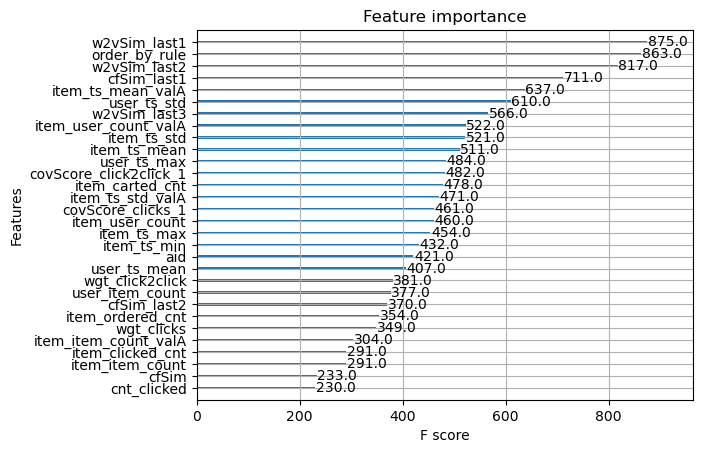

In [5]:
data4xgb_path = outputPath + f'data4xgb/set{SET}_top_{TOPN_candidate}/{input_note}'
for predictType in predictTypes:
    print(predictType)
    candidates = candidateArrange(data4xgb_path, predictType)
    modelName = f'xgb_{predictType}'
    modelSavedPAth = outputPath + f'savedModel_set{SET}/{modelName}_top_{TOPN_candidate}_{outputNote}/'
    try: 
        os.makedirs(modelSavedPAth) 
    except OSError as error: 
        print(error) 
    skf = GroupKFold(n_splits=5)
    predsVal = np.zeros(len(candidates))
    
    for fold,(train_idx, valid_idx) in enumerate(skf.split(candidates, candidates[predCols[predictType]], groups=candidates['session'] )):
        print('========= fold', fold, '==========')
        train = candidates.iloc[train_idx]
        val = candidates.iloc[valid_idx]

        train = train.sort_values('session')
        groupsTrain = train.groupby('session').aid.agg('count').values
        # dropCol = ['session', 'aid', predCols[predictType]]
        dropCol = ['session', predCols[predictType]]
        dtrain = xgb.DMatrix(train.drop(dropCol, axis=1), train[predCols[predictType]], group=groupsTrain)

        val = val.sort_values('session')
        groupsVal = val.groupby('session').aid.agg('count').values
        dvalid = xgb.DMatrix(val.drop(dropCol, axis=1), val[predCols[predictType]], group=groupsVal)

        model = xgb.train(xgb_parms, 
            dtrain=dtrain,
            evals=[(dtrain,'train'),(dvalid,'valid')],
            num_boost_round=type2num_boost_round[predictType],
            verbose_eval=100)
        model.save_model(modelSavedPAth + modelName + f'_fold{fold}.xgb')

    xgb.plot_importance(model, max_num_features=30)


## All train

In [4]:
def candidateArrange(data4xgb_path, predictType):
    for s in range(SUBSETNUM):
        data4xgb = pd.read_parquet(f'{data4xgb_path}/{predictType}_{s}.pqt').reset_index(drop=True)
        # toDrop = ['covScore_buy2buy_1', 'wgt_buy2buy', 'user_ts_diff_std', 'item_carted_cnt_val', 'user_ts_min']
        # data4xgb = data4xgb.drop(columns=toDrop)
        print(data4xgb.shape)

        positives = data4xgb.loc[data4xgb[predictType[:-1]] == 1]
        negatives = data4xgb.loc[data4xgb[predictType[:-1]] == 0]
        print(len(positives), len(negatives))
        negatives = negatives.sample(frac=underSampleRate[predictType])
        train = pd.concat([positives, negatives], axis=0, ignore_index=True)

        if s == 0:
            cand = train.copy()
        else:
            cand = pd.concat([cand, train], axis=0, ignore_index=True)

    cand.order_by_rule = cand.order_by_rule / TOPN_candidate
    return cand

orders
(33000000, 45)
40603 32959397
(33000000, 45)
38035 32961965
(24062550, 45)
27282 24035268
(33000000, 45)
37178 32962822
(33000000, 45)
39750 32960250
(24062550, 45)
33310 24029240
[Errno 17] File exists: '../output/newSplited/savedModel_set2/xgb_orders_top_100_final_3/'
[0]	train-map:0.99735
[99]	train-map:0.99817


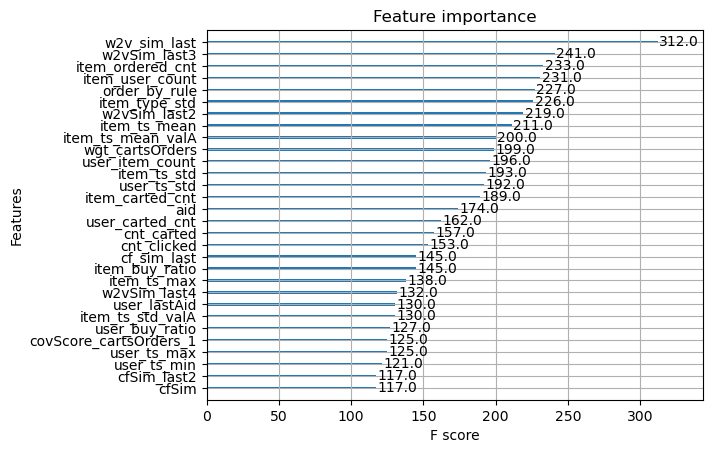

In [5]:
data4xgb_path = outputPath + f'data4xgb/set{SET}_top_{TOPN_candidate}/{input_note}'
for predictType in predictTypes:
    print(predictType)
    train= candidateArrange(data4xgb_path, predictType)
    modelName = f'xgb_{predictType}'
    modelSavedPAth = outputPath + f'savedModel_set{SET}/{modelName}_top_{TOPN_candidate}_{outputNote}/'
    
    try: 
        os.makedirs(modelSavedPAth) 
    except OSError as error: 
        print(error) 
        
    train = train.sort_values('session')
    groupsTrain = train.groupby('session').aid.agg('count').values
    # dropCol = ['session', 'aid', predCols[predictType]]
    dropCol = ['session', predCols[predictType]]
    dtrain = xgb.DMatrix(train.drop(dropCol, axis=1), train[predCols[predictType]], group=groupsTrain)

    model = xgb.train(xgb_parms, 
        dtrain=dtrain,
        evals=[(dtrain,'train')],
        num_boost_round=type2num_boost_round[predictType],
        verbose_eval=100)
    model.save_model(modelSavedPAth + modelName + f'.xgb')

    xgb.plot_importance(model, max_num_features=30)

## Train - validate

In [7]:
def candidateArrange(data4xgb_path, predictType):
    for s in range(SUBSETNUM):
        data4xgb = pd.read_parquet(f'{data4xgb_path}/{predictType}_{s}.pqt').reset_index(drop=True)
        # toDrop = ['covScore_buy2buy_1', 'wgt_buy2buy', 'user_ts_diff_std', 'item_carted_cnt_val', 'user_ts_min']
        # data4xgb = data4xgb.drop(columns=toDrop)
        print(data4xgb.shape)

        random.seed(10)
        uniqueUser = list(data4xgb.session.unique())
        val_User = random.sample(uniqueUser, int(len(uniqueUser)/10))

        train = data4xgb[~data4xgb.session.isin(val_User)].reset_index(drop=True)
        positives = train.loc[train[predictType[:-1]] == 1]
        negatives = train.loc[train[predictType[:-1]] == 0]
        print(len(positives), len(negatives))
        negatives = negatives.sample(frac=underSampleRate[predictType])
        train = pd.concat([positives, negatives], axis=0, ignore_index=True)
        # train = train.merge(aid2vec_df, on=['aid'], how='left')

        val = data4xgb[data4xgb.session.isin(val_User)].reset_index(drop=True)
        # val = val.merge(aid2vec_df, on=['aid'], how='left')

        if s == 0:
            candidates_train = train.copy()
            candidates_val = val.copy()
        else:
            candidates_train = pd.concat([candidates_train, train], axis=0, ignore_index=True)
            candidates_val = pd.concat([candidates_val, val], axis=0, ignore_index=True)

    # candidates = candidates.merge(aid2vec_df, on=['aid'], how='left')
    # candidates_train = candidates_train.sample(frac=0.7).reset_index(drop=True)
    candidates_train.order_by_rule = candidates_train.order_by_rule / TOPN_candidate
    candidates_val.order_by_rule = candidates_val.order_by_rule / TOPN_candidate
    return candidates_train, candidates_val

orders
(33000000, 45)
36621 29663379
(33000000, 45)
34041 29665959
(24062550, 45)
24581 21631769
(33000000, 45)
33491 29666609
(33000000, 45)
35701 29664399
(24062550, 45)
29995 21626355
[Errno 17] File exists: '../output/newSplited/savedModel_set2/xgb_orders_top_100_final_3/'
[0]	train-map:0.99733
[99]	train-map:0.99818
Validation recall: orders 0.6572620138384253


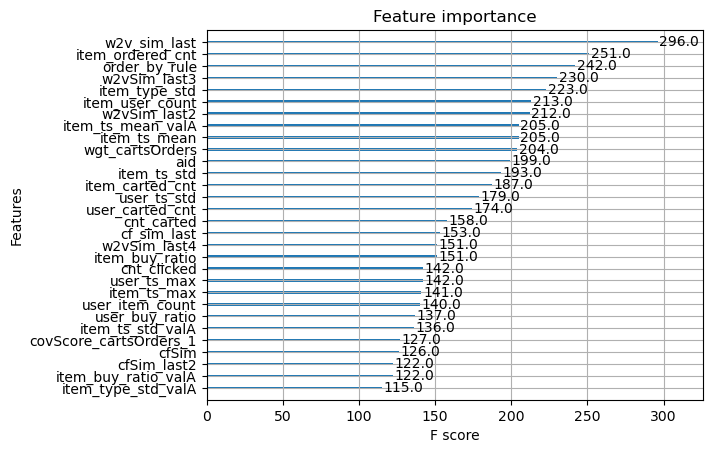

In [8]:
recall20 = {}
data4xgb_path = outputPath + f'data4xgb/set{SET}_top_{TOPN_candidate}/{input_note}'
for predictType in predictTypes:
    print(predictType)
    train, val = candidateArrange(data4xgb_path, predictType)
    modelName = f'xgb_{predictType}'
    modelSavedPAth = outputPath + f'savedModel_set{SET}/{modelName}_top_{TOPN_candidate}_{outputNote}/'
    
    try: 
        os.makedirs(modelSavedPAth) 
    except OSError as error: 
        print(error) 
        
    train = train.sort_values('session')
    groupsTrain = train.groupby('session').aid.agg('count').values
    # dropCol = ['session', 'aid', predCols[predictType]]
    dropCol = ['session', predCols[predictType]]
    dtrain = xgb.DMatrix(train.drop(dropCol, axis=1), train[predCols[predictType]], group=groupsTrain)

    model = xgb.train(xgb_parms, 
        dtrain=dtrain,
        evals=[(dtrain,'train')],
        num_boost_round=type2num_boost_round[predictType],
        verbose_eval=100)
    # model.save_model(modelSavedPAth + modelName + f'_fold{fold}.xgb')

    xgb.plot_importance(model, max_num_features=30)

    model.set_param({'predictor': 'gpu_predictor'})
    n = len(val)
    i = 0
    chunkSize = 5000000
    pred = np.array([])
    while (i * chunkSize < n):
        # dtest = xgb.DMatrix(data4xgb.iloc[i*chunkSize:(i+1)*chunkSize, 2:])
        dvalid = xgb.DMatrix(val.drop(dropCol, axis=1).iloc[i*chunkSize:(i+1)*chunkSize, :])
        pred = np.append(pred, model.predict(dvalid))
        i += 1

    predictions = val[['session','aid']].copy()
    predictions['pred'] = pred
    predictions = predictions.sort_values(['session','pred'], ascending=[True,False]).reset_index(drop=True)
    predictions['n'] = predictions.groupby('session').aid.cumcount().astype('int8')
    predictions = predictions.loc[predictions.n<20]

    predictions = predictions.groupby('session').aid.apply(list).to_frame().reset_index()
    predictions['type'] = predictType
    predictions.columns = ['session', 'labels', 'type']

    test_labels = pd.read_parquet('../input/splited/test_labels.parquet')
    test_labels = test_labels[test_labels['type'] == predictType]
    test_labels = test_labels.merge(predictions, how='left', on=['session', 'type']).dropna()
    test_labels['hits'] = test_labels.apply(lambda df: len(set(df.ground_truth).intersection(set(df.labels))), axis=1)
    test_labels['gt_count'] = test_labels.ground_truth.str.len().clip(0,20)
    recall_per_type = test_labels['hits'].sum() / test_labels['gt_count'].sum()
    recall20[predictType] = recall_per_type
    print('Validation recall:', predictType, recall_per_type)

In [22]:
print('Validation recall:', predictType, recall_per_type)

Validation recall: orders 0.6570724463682032


## Validate on Val Set2 (For SET==1)

In [ ]:
SET = 2
SUBSETNUM = 2
subsetRate = 0.5

predictTypes = ['clicks', 'carts', 'orders']
note_data4xgb = 'covisit_20_20_20_newSuggester2_moreCovwgt'
note_model = 'covisit_20_20_20_newSuggester2_moreCovwgt_clickTune'

In [ ]:
recall20 = {}
for predictType in predictTypes:
    print('================type:', predictType, '=================')
    modelName = f'xgb_{predictType}'
    modelSavedPAth = outputPath + f'savedModel_set1/{modelName}_top_{TOPN_candidate}_{note_model}/'
    data4xgb_path = outputPath + f'data4xgb_set2_top_{TOPN_candidate}_{note_data4xgb}/'

    toConcate = []
    for s in range(SUBSETNUM):
        sub = pd.read_parquet(data4xgb_path + f'data4xgb_{predictType}_{s}.pqt')
        random.seed(10)
        uniqueUser = list(sub.session.unique())
        keepUsers = random.sample(uniqueUser, int(len(uniqueUser)*subsetRate))
        sub = sub[sub.session.isin(keepUsers)].reset_index(drop=True)
        toConcate.append(sub)
    data4xgb = pd.concat(toConcate, axis=0)
    print(data4xgb.shape)

    print('merge w2v features...')
    data4xgb = data4xgb.merge(aid2vec_df, on=['aid'], how='left')
    # Normalize orderofRule
    data4xgb.order_by_rule = data4xgb.order_by_rule / TOPN_candidate
    
    preds = np.zeros(len(data4xgb))
    for fold in range(5):
        print('======= fold', fold, '===========')
        model = xgb.Booster()
        model.load_model(modelSavedPAth + modelName + f'_fold{fold}.xgb')
        model.set_param({'predictor': 'gpu_predictor'})

        chunkSize = 10000000
        n = len(data4xgb)
        i = 0
        pred = np.array([])
        while (i * chunkSize < n):
            dtest = xgb.DMatrix(data4xgb.iloc[i*chunkSize:(i+1)*chunkSize, 2:])
            pred = np.append(pred, model.predict(dtest))
            i += 1
        preds += pred/5

    predictions = data4xgb[['session','aid']].copy()
    predictions['pred'] = preds
    predictions = predictions.sort_values(['session','pred'], ascending=[True,False]).reset_index(drop=True)
    predictions['n'] = predictions.groupby('session').aid.cumcount().astype('int8')
    predictions = predictions.loc[predictions.n<20]

    predictions = predictions.groupby('session').aid.apply(list).to_frame().reset_index()
    predictions['type'] = predictType
    predictions.columns = ['session', 'labels', 'type']
    test_labels = pd.read_parquet('../input/splited/test_labels.parquet')
    test_labels = test_labels[test_labels['type'] == predictType]
    test_labels = test_labels.merge(predictions, how='left', on=['session', 'type']).dropna()
    test_labels['hits'] = test_labels.apply(lambda df: len(set(df.ground_truth).intersection(set(df.labels))), axis=1)
    test_labels['gt_count'] = test_labels.ground_truth.str.len().clip(0,20)
    recall_per_type = test_labels['hits'].sum() / test_labels['gt_count'].sum()
    recall20[predictType] = recall_per_type
    print('Validation recall:', predictType, recall_per_type)

In [ ]:
score = recall20['clicks']*0.1 + recall20['carts']*0.3 + recall20['orders']*0.6

In [ ]:
print(recall20)
print(score)

{'clicks': 0.5322509922725176, 'carts': 0.4172493363637941, 'orders': 0.6406665369902095}
0.5627998223305156
